## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import importlib
import glob
import cv2
%matplotlib qt
import matplotlib.image as mpimg
import sys
import os
sys.path.append('sources')
import calibration as cb;
# Make a list of calibration images
input_path = "camera_cal/"
images = glob.glob(input_path + 'calibration*.jpg')
chess_calibration_points = cb.Chess_calibration_points(images, [9,6])


## Apply the disturtion to chess images

In [2]:
#apply disturtion coefficients to the chess images
out_path = "output_images/calibration/";
for filename in os.listdir(input_path):
    image = mpimg.imread(  os.path.join( input_path, filename ))    
    undist = chess_calibration_points.undist_image(image);
    cv2.imwrite(os.path.join(out_path , filename), undist, [cv2.IMWRITE_JPEG_QUALITY, 100])

## Apply calibration to the road images and provide the binary images

In [3]:
import binary_outputs as bo
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_binary(img):
    hls_s_binary = bo.get_hls_s_binary(img, (150, 255));
    scale_x_binary = bo.get_sobel_binary(img, (20, 100));
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(hls_s_binary)
    combined_binary[(hls_s_binary == 1) | (scale_x_binary == 1)] = 1
    return combined_binary;

input_path  = './test_images/'
#apply disturtion coefficients to the chess images
out_path = "output_images/binaries/";
for filename in os.listdir(input_path):
    image = mpimg.imread(  os.path.join( input_path, filename ))    
    undist = chess_calibration_points.undist_image(image);
    binary = get_binary(undist)
    cv2.imwrite(os.path.join(out_path , filename), bo.to_binary_image(binary), [cv2.IMWRITE_JPEG_QUALITY, 100])


## Apply a perspective transform to rectify binary image ("birds-eye view").

In [4]:
import sys
import os
sys.path.append('sources')
import transformation as tr
import matplotlib.pyplot as plt
%matplotlib inline


def get_model_polygon (img):
    img_size = [img.shape[1], img.shape[0]]
    src = np.float32(
     [[(img_size[0] * 11/ 24), img_size[1] * 5/8],
     [((img_size[0] / 8) ), img_size[1]],
     [(img_size[0] *  7 / 8) , img_size[1]],
     [(img_size[0] * 13 / 24), img_size[1] * 5 / 8]])
    dst = np.float32(
     [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])
    return src, dst

input_path  = './test_images/'
out_path = "output_images/bird_eye/";
warper = [];
for filename in os.listdir(input_path):
    image = mpimg.imread(  os.path.join( input_path, filename ))    
    undist = chess_calibration_points.undist_image(image);
    if not warper:
        src, dst = get_model_polygon(image)
        warper = tr.ImageWarper( src, dst);
    rgbImg = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)            
    wrap_img = warper.warp_image(rgbImg);        
    cv2.polylines(wrap_img, [dst.astype(int)], True, (0,255,0), 2)
    cv2.imwrite(os.path.join(out_path , filename), wrap_img, [cv2.IMWRITE_JPEG_QUALITY, 100])    
    


## Apply the same transformation for the binary images

In [5]:
out_path = "output_images/bird_eye_binaries"

for filename in os.listdir(input_path):
    image = mpimg.imread(  os.path.join( input_path, filename ))    
    undist = chess_calibration_points.undist_image(image);
    binary = get_binary(undist)
    wrap_img = warper.warp_image(binary)
    cv2.imwrite(os.path.join(out_path , filename), bo.to_binary_image(wrap_img), [cv2.IMWRITE_JPEG_QUALITY, 100])

## Detect lane pixels and fit to find the lane boundary.

In [6]:
import lane_detection as ld
import matplotlib.pyplot as plt

out_path = "output_images/lane_detection_bird_eye"

for filename in os.listdir(input_path):
    image = mpimg.imread(  os.path.join( input_path, filename ))    
    undist = chess_calibration_points.undist_image(image);
    binary = get_binary(undist)
    wrap_img = warper.warp_image(binary)
    # View your output
    lane_detector = ld.LaneDetector(wrap_img)
    result = lane_detector.draw_the_lines(wrap_img)
    cv2.imwrite(os.path.join(out_path , filename), result, [cv2.IMWRITE_JPEG_QUALITY, 100])


## Provide full lane detection for the all test images

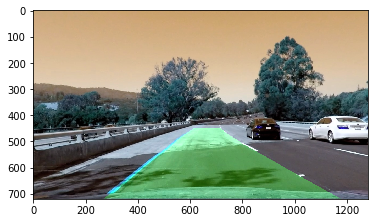

In [9]:
import lane_detection as ld
import matplotlib.pyplot as plt

out_path = "output_images/lane_detection"

inverted_warper = tr.ImageWarper( dst, src);

for filename in os.listdir(input_path):
    image = mpimg.imread(  os.path.join( input_path, filename ))    
    undist = chess_calibration_points.undist_image(image);
    binary = get_binary(undist)
    warp_img = warper.warp_image(binary)
    # View your output
    lane_detector = ld.LaneDetector(warp_img)
    lane_boundaries = lane_detector.get_the_polygon_image(warp_img)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = inverted_warper.warp_image(lane_boundaries) 
    # Combine the result with the original image
    rgbImg = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)  
    result = cv2.addWeighted(rgbImg, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    cv2.imwrite(os.path.join(out_path , filename), result, [cv2.IMWRITE_JPEG_QUALITY, 100])